<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/generative/stable_diffusion_inpaint_dreambooth_v1_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade diffusers transformers accelerate

In [2]:
!git clone https://github.com/huggingface/diffusers.git

Cloning into 'diffusers'...
remote: Enumerating objects: 18442, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18442 (delta 8), reused 13 (delta 3), pack-reused 18420
Receiving objects: 100% (18442/18442), 12.28 MiB | 5.33 MiB/s, done.
Resolving deltas: 100% (12890/12890), done.


In [2]:
%cd diffusers/examples/research_projects/dreambooth_inpaint

/content/diffusers/examples/research_projects/dreambooth_inpaint


In [12]:
MODEL_NAME="runwayml/stable-diffusion-inpainting"
INSTANCE_DIR = "/content/images"
OUTPUT_DIR="/content/results"

In [9]:
!pip install -qq git+https://github.com/huggingface/diffusers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!nvidia-smi

In [ ]:
!pip install bitsandbytes

In [ ]:
!accelerate launch train_dreambooth_inpaint.py --pretrained_model_name=$MODEL_NAME --instance_data_dir=$INSTANCE_DIR --output_dir=$OUTPUT_DIR --instance_prompt="a photo of anya" --resolution=512 --train_batch_size=1 --gradient_accumulation_steps=2 --gradient_checkpointing --use_8bit_adam --learning_rate=5e-6 --lr_scheduler="constant" --lr_warmup_steps=0 --max_train_steps=800

In [2]:
OUTPUT_DIR = "/content/results"

In [3]:
#@title inference
import torch
from torch import autocast
from diffusers import StableDiffusionInpaintPipeline, DDIMScheduler

model_path=OUTPUT_DIR

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionInpaintPipeline.from_pretrained(model_path, scheduler=scheduler, safety_checker=None, torch_dtype=torch.float16).to("cuda")
g_cuda = None
 
# seed setting
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [4]:
from PIL import Image, ImageDraw

img_w, img_h = 512, 512
 
init_image = Image.open("/content/woman.jpeg").resize((img_w, img_h))
mask_image = Image.open("/content/woman_mask.png").resize((img_w, img_h))


In [5]:
# prompt
prompt = "anya portrait" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
 
# other setting
num_samples = 1 
guidance_scale = 7.5 
num_inference_steps = 50 
height = 512 
width = 512 
 
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        image=init_image,
        mask_image=mask_image,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

  0%|          | 0/50 [00:00<?, ?it/s]

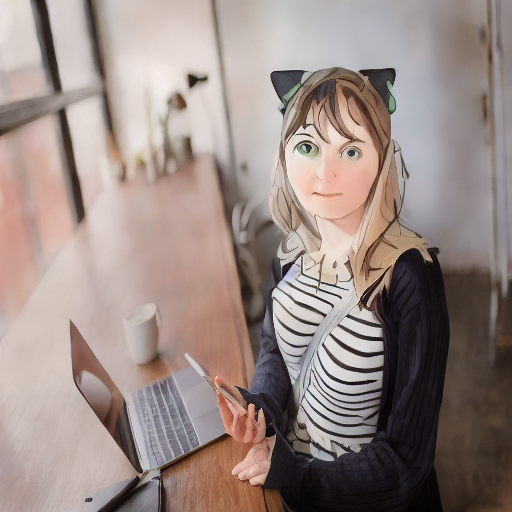

In [6]:
display(images[0])